pip install --upgrade numpy

pip install graphviz

In [5]:
import gensim
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten, TextVectorization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model, pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import activations
from sklearn.model_selection import train_test_split


2023-07-04 04:12:33.700673: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
import pandas as pd
import cufflinks as cf;
# cf.go_offline()

In [2]:
wine_reviews = pd.read_csv("wine_reviews.csv")
wine_reviews.shape

(129908, 19)

In [3]:
categorical_features =  ['country','province','region_1','variety','winery','year']
numerical_features = ['price']
description_features = ['description']

In [27]:
distinct_values = wine_reviews['winery'].unique()
distinct_values.shape

(16745,)

In [6]:
wine_reviews_dl = wine_reviews[categorical_features+numerical_features+description_features+['points']]
wine_reviews_dl
# wine_reviews_dl = wine_reviews_dl[~wine_reviews_dl['points'].str.contains('NV', na=False)]
np.where(wine_reviews_dl=='NV')
indices = np.where(wine_reviews_dl == 'NV')
wine_reviews_dl = wine_reviews_dl.drop(indices[0])
wine_reviews_dl.shape


(125280, 9)

In [7]:
from sklearn.model_selection import train_test_split
# Split the data into train and test sets
wine_reviews_X = wine_reviews_dl.drop(columns='points').head(10000)
wine_reviews_y = wine_reviews_dl['points'].head(10000)

X_train, X_test, y_train, y_test = train_test_split(wine_reviews_X, wine_reviews_y, test_size=0.2, random_state=17)

np.where(X_test=='NV')

(array([], dtype=int64), array([], dtype=int64))

## Preprocessing

In [8]:
for feature in categorical_features:
    wine_reviews_X[feature] = pd.Categorical(wine_reviews_X[feature]).codes.astype('float32')
    X_train[feature] = pd.Categorical(X_train[feature]).codes.astype('float32')
    X_test[feature] = pd.Categorical(X_test[feature]).codes.astype('float32')

    print(type(X_train[feature].iloc[0]))
    

wine_reviews_X.isnull().sum().sum()
# for feature in categorical_features:
wine_reviews_X.winery.isnull().sum().sum()
# Check for missing values in desc_1024_pad and X_train['winery']
# print("Missing values in desc_1024_pad:", np.isnan(desc_1024_pad).any())
# print("Missing values in X_train['winery']:", X_train['winery'].isnull().any())
# print("Shape of desc_1024_pad:", desc_1024_pad.shape)
# print("Shape of X_train['winery']:", X_train['winery'].shape)
# print("Shape of y_train:", y_train.shape)
# np.where(np.isnan(wine_reviews_X['variety']))


<class 'numpy.float32'>
<class 'numpy.float32'>
<class 'numpy.float32'>
<class 'numpy.float32'>
<class 'numpy.float32'>
<class 'numpy.float32'>


0

In [36]:
distinct_values_winery = X_train['winery'].unique()
distinct_values_variety = X_train['variety'].unique()
distinct_values_country = X_train['country'].unique()
distinct_values_year = X_train['year'].unique()


print(distinct_values_winery.shape)
print(distinct_values_variety.shape)
print(distinct_values_country.shape)
print(distinct_values_year.shape)

(4720,)
(306,)
(34,)
(28,)


In [9]:
minmax = MinMaxScaler()
wine_reviews_y = minmax.fit_transform([wine_reviews_y])
# y_train = minmax.fit_transform([y_train])


In [10]:
max_desc_len = max(wine_reviews.description_len)
max_desc_len

135

In [11]:
# y_train = y_train.values.reshape((-1,))
# y_train = y_train.values.reshape((-1,))

In [14]:
tokenizer_1024 = Tokenizer(num_words=1024)
tokenizer_1024.fit_on_texts(X_train.description)
desc_1024 = tokenizer_1024.texts_to_sequences(X_train.description)
# tokenizer_1024.word_index

In [15]:
print(X_train['year'].dtype)
X_train['year'] = X_train['year'].astype(np.float32)
# print("Shape of desc_1024_pad:", desc_1024_pad.shape)
print("Shape of X_train['year']:", X_train['year'].shape)

float32
Shape of X_train['year']: (8000,)


In [16]:
# desc_1024_pad = pad_sequences(desc_1024,truncating='post', maxlen=128)
# desc_1024_pad
# new_column = pd.Series(desc_1024_pad.flatten(), name='description')

# X_train.description= [ arr for arr in desc_1024_pad]

# X_train.description.shape[1]


In [37]:
# # Define the graph model
# # Categorical inputs
# cat_input_1 = Input(shape=(1,))
# embedding_1 = Embedding(input_dim=2, output_dim=2)(cat_input_1)
# flat_embed_1 = Flatten()(embedding_1)

# cat_input_2 = Input(shape=(1,))
# embedding_2 = Embedding(input_dim=4, output_dim=2)(cat_input_2)
# flat_embed_2 = Flatten()(embedding_2)

# cat_input_3 = Input(shape=(1,))
# embedding_3 = Embedding(input_dim=4, output_dim=2)(cat_input_3)
# flat_embed_3 = Flatten()(embedding_3)

# cat_input_4 = Input(shape=(1,))
# embedding_4 = Embedding(input_dim=4, output_dim=2)(cat_input_4)
# flat_embed_4 = Flatten()(embedding_2)

# cat_input_5 = Input(shape=(1,))
# embedding_5 = Embedding(input_dim=4, output_dim=2)(cat_input_5)
# flat_embed_5 = Flatten()(embedding_5)

# cat_input_6 = Input(shape=(1,))
# embedding_6 = Embedding(input_dim=4, output_dim=2)(cat_input_6)
# flat_embed_6 = Flatten()(embedding_6)


# # Embedding layers for textual features
# embedding_dim = 16
# text_input_3 = Input(shape=(128,))
# embedding_3 = Embedding(input_dim=128, output_dim=embedding_dim)(text_input_3)
# flat_embed_3 = Flatten()(embedding_3)

# text_input = Input(shape=(128,))
# embedding_dim = 50  # Dimension of the embedding vectors
# embedding_layer = Embedding(input_dim=128, output_dim=embedding_dim, input_length=128)(text_input)
# flatten_embedding = Flatten()(embedding_layer)
# # Numerical inputs
# num_input = Input(shape=(1,))

# # Concatenate categorical embeddings with numerical inputs
# concatenated = Concatenate()([flat_embed_1,flat_embed_2,flat_embed_3,flat_embed_4,flat_embed_5,flat_embed_6, flat_embed_2,flat_embed_3])

# # Dense layers for classification
# x = Dense(16, activation='relu')(concatenated)
# x = Dense(8, activation='relu')(x)
# outputs = Dense(1, activation='sigmoid')(x)

# # Create the model
# model = Model(inputs=[cat_input_1,cat_input_2,cat_input_3,cat_input_4,cat_input_5,cat_input_6, num_input,text_input_3], outputs=outputs)


In [38]:
# plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True, to_file='model_1.png')

In [39]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import Accuracy
# from tensorflow.keras.losses import BinaryCrossentropy
# from tensorflow.keras.utils import to_categorical, plot_model
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss=BinaryCrossentropy(),
#               metrics=[Accuracy()])

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

max_words = 1024  # Maximum number of words to consider

tokenizer_1024 = Tokenizer(num_words=1024)
tokenizer_1024.fit_on_texts(X_train.description)
desc_1024 = tokenizer_1024.texts_to_sequences(X_train.description)
max_seq_length = max(len(seq) for seq in desc_1024)




desc_1024_pad = pad_sequences(desc_1024, truncating='post', maxlen=max_seq_length)
text_input_1 = Input(shape=(max_seq_length,))

# # Split the data into training and testing sets
# X_train_text1, X_test_text1, y_train1, y_test1 = train_test_split(
#     df, y_train, test_size=0.2, random_state=42
# )
tokenizer_1024_test = Tokenizer(num_words=1024)
tokenizer_1024_test.fit_on_texts(X_test.description)
desc_1024_test = tokenizer_1024.texts_to_sequences(X_test.description)
max_seq_length_test = max(len(seq) for seq in desc_1024_test)
# df = pd.DataFrame({'winery': X_train['winery'], 'desc_1024': desc_1024_pad})
desc_1024_pad_test = pad_sequences(desc_1024_test, truncating='post', maxlen=max_seq_length)



cat_input_1 = Input(shape=(1,))
embedding_1 = Embedding(input_dim=4720, output_dim=1)(cat_input_1)
flat_embed_1 = Flatten()(embedding_1)

# Embedding layers for textual features
embedding_dim = 128
embedding_1 = Embedding(input_dim=max_words, output_dim=embedding_dim)(text_input_1)
flatten_1 = Flatten()(embedding_1)

# Concatenate flattened embeddings with dense layers for regression
concatenated = Flatten()(flatten_1)  # Remove extra Flatten layer
x = Dense(256, activation='relu')(concatenated)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='linear')(x)  # Use linear activation for continuous target variable

# Define the model
model = Model(inputs=[text_input_1], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=MeanSquaredError(),
              metrics=[MeanAbsoluteError()])

# Train the model
model.fit([desc_1024_pad], y_train,
          batch_size=32,
          epochs=10,
          validation_data=([desc_1024_pad_test], y_test))

# Evaluate the model
loss, mae = model.evaluate([desc_1024_pad_test], y_test)
print('Test Loss:', loss)
print('Test MAE:', mae)

Epoch 1/10
250/250 [==============================] - 11s 41ms/step - loss: 415.2439 - mean_absolute_error: 9.0157 - val_loss: 6.9730 - val_mean_absolute_error: 1.9828
Epoch 2/10
250/250 [==============================] - 10s 40ms/step - loss: 5.0332 - mean_absolute_error: 1.7215 - val_loss: 4.7617 - val_mean_absolute_error: 1.6725
Epoch 3/10
250/250 [==============================] - 10s 41ms/step - loss: 3.6893 - mean_absolute_error: 1.5104 - val_loss: 4.3559 - val_mean_absolute_error: 1.6079
Epoch 4/10
250/250 [==============================] - 10s 40ms/step - loss: 3.0518 - mean_absolute_error: 1.3791 - val_loss: 4.1393 - val_mean_absolute_error: 1.5919
Epoch 5/10
250/250 [==============================] - 10s 41ms/step - loss: 2.5756 - mean_absolute_error: 1.2682 - val_loss: 4.3266 - val_mean_absolute_error: 1.6191
Epoch 6/10
250/250 [==============================] - 10s 40ms/step - loss: 2.0981 - mean_absolute_error: 1.1444 - val_loss: 4.3708 - val_mean_absolute_error: 1.6458
Ep

In [32]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import MeanSquaredError
# from tensorflow.keras.metrics import MeanAbsoluteError

# max_words = 1024  # Maximum number of words to consider

# tokenizer_1024 = Tokenizer(num_words=1024)
# tokenizer_1024.fit_on_texts(X_train.description)
# desc_1024 = tokenizer_1024.texts_to_sequences(X_train.description)
# max_seq_length = max(len(seq) for seq in desc_1024)




# desc_1024_pad = pad_sequences(desc_1024, truncating='post', maxlen=max_seq_length)
# text_input_1 = Input(shape=(max_seq_length,))

# # # Split the data into training and testing sets
# # X_train_text1, X_test_text1, y_train1, y_test1 = train_test_split(
# #     df, y_train, test_size=0.2, random_state=42
# # )
# tokenizer_1024_test = Tokenizer(num_words=1024)
# tokenizer_1024_test.fit_on_texts(X_test.description)
# desc_1024_test = tokenizer_1024.texts_to_sequences(X_test.description)
# max_seq_length_test = max(len(seq) for seq in desc_1024_test)
# # df = pd.DataFrame({'winery': X_train['winery'], 'desc_1024': desc_1024_pad})
# desc_1024_pad_test = pad_sequences(desc_1024_test, truncating='post', maxlen=max_seq_length)



# cat_input_1 = Input(shape=(1,))
# embedding_1 = Embedding(input_dim=4720, output_dim=16)(cat_input_1)
# flat_embed_1 = Flatten()(embedding_1)

# # Embedding layers for textual features
# embedding_dim = 128
# embedding_1_text = Embedding(input_dim=max_words, output_dim=embedding_dim)(text_input_1)
# flatten_1 = Flatten()(embedding_1_text)

# # Concatenate flattened embeddings with dense layers for regression
# concatenated = Flatten()([flatten_1,flat_embed_1])  # Remove extra Flatten layer
# x = Dense(256, activation='relu')(concatenated)
# x = Dense(32, activation='relu')(x)
# output = Dense(1, activation='linear')(x)  # Use linear activation for continuous target variable

# # Define the model
# model = Model(inputs=[text_input_1,cat_input_1], outputs=output)

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss=MeanSquaredError(),
#               metrics=[MeanAbsoluteError()])

# # Train the model
# model.fit([desc_1024_pad,X_train['winery']], y_train,
#           batch_size=32,
#           epochs=10,
#           validation_data=([desc_1024_pad_test,X_test['winery']], y_test))

# # Evaluate the model
# loss, mae = model.evaluate([desc_1024_pad_test,X_test['winery']], y_test)
# print('Test Loss:', loss)
# print('Test MAE:', mae)

In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 1024  # Maximum number of words to consider

tokenizer_1024 = Tokenizer(num_words=1024)
tokenizer_1024.fit_on_texts(X_train.description)
desc_1024 = tokenizer_1024.texts_to_sequences(X_train.description)
max_seq_length = max(len(seq) for seq in desc_1024)

desc_1024_pad = pad_sequences(desc_1024, truncating='post', maxlen=max_seq_length)
text_input_1 = Input(shape=(max_seq_length,))

tokenizer_1024_test = Tokenizer(num_words=1024)
tokenizer_1024_test.fit_on_texts(X_test.description)
desc_1024_test = tokenizer_1024.texts_to_sequences(X_test.description)
max_seq_length_test = max(len(seq) for seq in desc_1024_test)

desc_1024_pad_test = pad_sequences(desc_1024_test, truncating='post', maxlen=max_seq_length)

cat_input_1 = Input(shape=(1,))
embedding_1 = Embedding(input_dim=4720, output_dim=16)(cat_input_1)
flat_embed_1 = Flatten()(embedding_1)

embedding_dim = 128
embedding_1_text = Embedding(input_dim=max_words, output_dim=embedding_dim)(text_input_1)
flatten_1 = Flatten()(embedding_1_text)

concatenated = Concatenate()([flatten_1, flat_embed_1])
x = Dense(256, activation='relu')(concatenated)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='linear')(x)

model = Model(inputs=[text_input_1, cat_input_1], outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=MeanSquaredError(),
              metrics=[MeanAbsoluteError()])

model.fit([desc_1024_pad, X_train['winery']], y_train,
          batch_size=32,
          epochs=10,
          validation_data=([desc_1024_pad_test, X_test['winery']], y_test))

loss, mae = model.evaluate([desc_1024_pad_test, X_test['winery']], y_test)
print('Test Loss:', loss)
print('Test MAE:', mae)

Epoch 1/10
250/250 [==============================] - 11s 42ms/step - loss: 425.8490 - mean_absolute_error: 9.1946 - val_loss: 8.3840 - val_mean_absolute_error: 2.2669
Epoch 2/10
250/250 [==============================] - 10s 40ms/step - loss: 5.0061 - mean_absolute_error: 1.7213 - val_loss: 4.9135 - val_mean_absolute_error: 1.7096
Epoch 3/10
250/250 [==============================] - 10s 39ms/step - loss: 2.7672 - mean_absolute_error: 1.2778 - val_loss: 5.0459 - val_mean_absolute_error: 1.7626
Epoch 4/10
250/250 [==============================] - 10s 39ms/step - loss: 1.6610 - mean_absolute_error: 0.9693 - val_loss: 5.6753 - val_mean_absolute_error: 1.8793
Epoch 5/10
250/250 [==============================] - 10s 39ms/step - loss: 1.1840 - mean_absolute_error: 0.8074 - val_loss: 6.2543 - val_mean_absolute_error: 1.9865
Epoch 6/10
250/250 [==============================] - 10s 39ms/step - loss: 0.8737 - mean_absolute_error: 0.7000 - val_loss: 6.3666 - val_mean_absolute_error: 2.0025
Ep

In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 1024  # Maximum number of words to consider

tokenizer_1024 = Tokenizer(num_words=1024)
tokenizer_1024.fit_on_texts(X_train.description)
desc_1024 = tokenizer_1024.texts_to_sequences(X_train.description)
max_seq_length = max(len(seq) for seq in desc_1024)

desc_1024_pad = pad_sequences(desc_1024, truncating='post', maxlen=max_seq_length)
text_input_1 = Input(shape=(max_seq_length,))

tokenizer_1024_test = Tokenizer(num_words=1024)
tokenizer_1024_test.fit_on_texts(X_test.description)
desc_1024_test = tokenizer_1024.texts_to_sequences(X_test.description)
max_seq_length_test = max(len(seq) for seq in desc_1024_test)

desc_1024_pad_test = pad_sequences(desc_1024_test, truncating='post', maxlen=max_seq_length)


# winery
cat_input_1 = Input(shape=(1,))
embedding_1 = Embedding(input_dim=4720, output_dim=16)(cat_input_1)
flat_embed_1 = Flatten()(embedding_1)

#variety
cat_input_2 = Input(shape=(1,))
embedding_2 = Embedding(input_dim=306, output_dim=16)(cat_input_2)
flat_embed_2 = Flatten()(embedding_1)

#country 
cat_input_3 = Input(shape=(1,))
embedding_3 = Embedding(input_dim=34, output_dim=16)(cat_input_3)
flat_embed_3 = Flatten()(embedding_1) 


#year
cat_input_4 = Input(shape=(1,))
embedding_4 = Embedding(input_dim=28, output_dim=16)(cat_input_4)
flat_embed_4 = Flatten()(embedding_1)  

embedding_dim = 128
embedding_1_text = Embedding(input_dim=max_words, output_dim=embedding_dim)(text_input_1)
flatten_1 = Flatten()(embedding_1_text)

concatenated = Concatenate()([flatten_1, flat_embed_1,flat_embed_2,flat_embed_3])
x = Dense(256, activation='relu')(concatenated)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='linear')(x)

model = Model(inputs=[text_input_1, cat_input_1,cat_input_2,cat_input_3], outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=MeanSquaredError(),
              metrics=[MeanAbsoluteError()])

model.fit([desc_1024_pad,X_train['winery'], X_train['variety'],X_train['country']], y_train,
          batch_size=32,
          epochs=10,
          validation_data=([desc_1024_pad_test,X_test['winery'],X_test['variety'],X_test['country']], y_test))

loss, mae = model.evaluate([desc_1024_pad_test,X_test['winery'],X_test['variety'],X_test['country']], y_test)
print('Test Loss:', loss)
print('Test MAE:', mae)

Epoch 1/10
250/250 [==============================] - 11s 43ms/step - loss: 356.6086 - mean_absolute_error: 8.4225 - val_loss: 6.6383 - val_mean_absolute_error: 1.9521
Epoch 2/10
250/250 [==============================] - 11s 42ms/step - loss: 4.4774 - mean_absolute_error: 1.6238 - val_loss: 4.9672 - val_mean_absolute_error: 1.7318
Epoch 3/10
250/250 [==============================] - 11s 42ms/step - loss: 2.3793 - mean_absolute_error: 1.1802 - val_loss: 5.8028 - val_mean_absolute_error: 1.8910
Epoch 4/10
250/250 [==============================] - 10s 41ms/step - loss: 1.4933 - mean_absolute_error: 0.9322 - val_loss: 6.1450 - val_mean_absolute_error: 1.9575
Epoch 5/10
250/250 [==============================] - 11s 42ms/step - loss: 1.0158 - mean_absolute_error: 0.7557 - val_loss: 6.2787 - val_mean_absolute_error: 1.9871
Epoch 6/10
250/250 [==============================] - 10s 41ms/step - loss: 0.7329 - mean_absolute_error: 0.6416 - val_loss: 6.5869 - val_mean_absolute_error: 2.0294
Ep

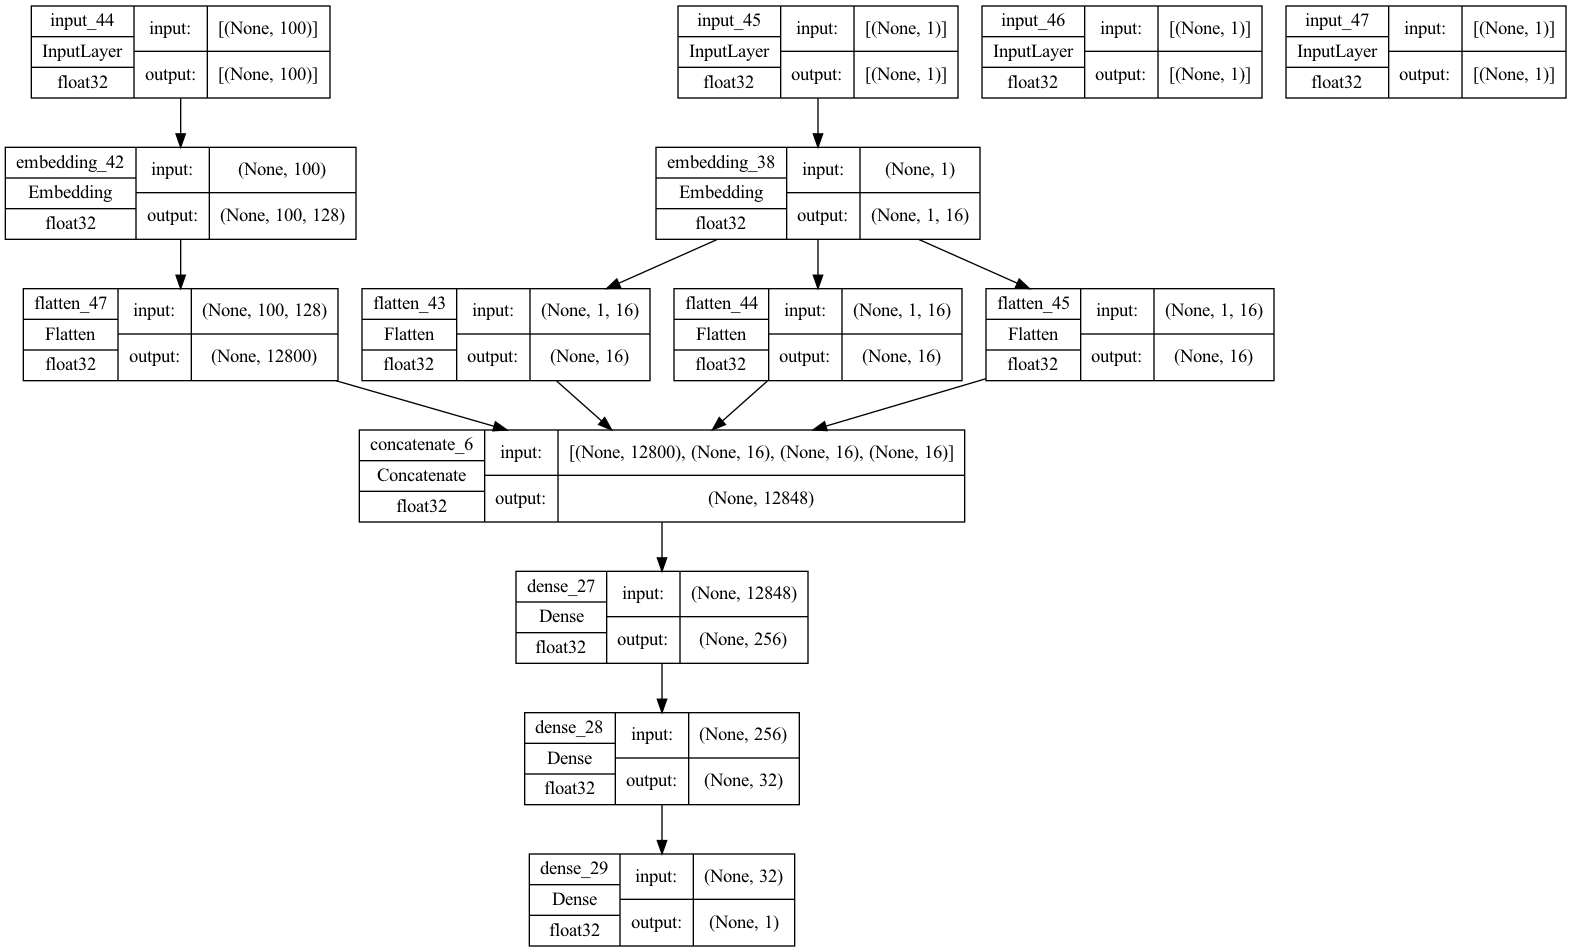

In [48]:
plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True, to_file='model_1.png')

In [22]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import MeanSquaredError
# from tensorflow.keras.metrics import MeanAbsoluteError

# max_words = 1024  # Maximum number of words to consider


# tokenizer_1024 = Tokenizer(num_words=1024)
# tokenizer_1024.fit_on_texts(X_test.description)
# desc_1024_test = tokenizer_1024.texts_to_sequences(X_test.description)

# max_seq_length_test = max(len(seq) for seq in desc_1024)
# desc_1024_pad_test = pad_sequences(desc_1024_test, truncating='post', maxlen=max_seq_length_test)
# text_input_1_test = Input(shape=(max_seq_length_test,))

# tokenizer_1024 = Tokenizer(num_words=1024)
# tokenizer_1024.fit_on_texts(X_train.description)
# desc_1024 = tokenizer_1024.texts_to_sequences(X_train.description)
# max_seq_length = max(len(seq) for seq in desc_1024)

# desc_1024_pad = pad_sequences(desc_1024, truncating='post', maxlen=max_seq_length)
# text_input_1 = Input(shape=(max_seq_length,))

# cat_input_1 = Input(shape=(1,))
# num_categories = len(X_train['year'].unique()) # Add 1 for an unknown category
# embedding_1 = Embedding(input_dim=num_categories, output_dim=embedding_dim)(cat_input_1)
# flat_embed_1 = Flatten()(embedding_1)

# # Embedding layers for textual features
# embedding_dim = 128
# embedding_2 = Embedding(input_dim=max_words, output_dim=embedding_dim)(text_input_1)
# flatten_2 = Flatten()(embedding_2)

# # Concatenate flattened embeddings with dense layers for regression
# concatenated = Concatenate()([flatten_2, flat_embed_1])
# x = Dense(256, activation='relu')(concatenated)
# x = Dense(32, activation='relu')(x)
# output = Dense(1, activation='linear')(x)  # Use linear activation for continuous target variable

# # Define the model
# model = Model(inputs=[cat_input_1], outputs=output)

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss=MeanSquaredError(),
#               metrics=[MeanAbsoluteError()])

# # Train the model
# model.fit([X_train['year']], y_train,
#           batch_size=32,
#           epochs=10,
#           validation_data=([X_test['year']], y_test))

# # Evaluate the model
# loss, mae = model.evaluate([X_test['year']], y_test)
# print('Test Loss:', loss)
# print('Test MAE:', mae)


In [23]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Embedding, Dense, Flatten
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import MeanSquaredError
# from tensorflow.keras.metrics import MeanAbsoluteError

# cat_input_1 = Input(shape=(1,))
# num_categories = len(X_train['year'].unique())  # Add 1 for an unknown category
# embedding_dim = 128
# embedding_1 = Embedding(input_dim=num_categories, output_dim=embedding_dim)(cat_input_1)
# flatten_1 = Flatten()(embedding_1)

# x = Dense(256, activation='relu')(flatten_1)
# x = Dense(32, activation='relu')(x)
# output = Dense(1, activation='linear')(x)  # Use linear activation for continuous target variable

# # Define the model
# model = Model(inputs=[cat_input_1], outputs=output)

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss=MeanSquaredError(),
#               metrics=[MeanAbsoluteError()])

# # Train the model
# model.fit(X_train['year'], y_train,
#           batch_size=32,
#           epochs=10,
#           validation_data=(X_test['year'], y_test))

# # Evaluate the model
# loss, mae = model.evaluate(X_test['year'], y_test)
# print('Test Loss:', loss)
# print('Test MAE:', mae)

In [24]:
# max_words = 1024  # Maximum number of words to consider


# tokenizer_1024 = Tokenizer(num_words=1024)
# tokenizer_1024.fit_on_texts(X_train.description)
# desc_1024 = tokenizer_1024.texts_to_sequences(X_train.description)
# max_seq_length = max(len(seq) for seq in desc_1024)

# desc_1024_pad = pad_sequences(desc_1024,truncating='post', maxlen=max_seq_length)
# text_input_1 = Input(shape=(max_seq_length,))

In [25]:
# # Split the data into training and testing sets
# X_train_text1, X_test_text1, y_train1, y_test1 = train_test_split(
#     desc_1024_pad, y_train, test_size=0.2, random_state=42
# )

In [26]:
# # Embedding layers for textual features
# embedding_dim = 128
# embedding_1 = Embedding(input_dim=max_words, output_dim=embedding_dim)(text_input_1)
# # Flatten the embeddings
# flatten_1 = Flatten()(embedding_1)

In [151]:

# # Concatenate flattened embeddings with dense layers for classification
# concatenated = Concatenate()([flatten_1])
# x = Dense(128, activation='relu')(concatenated)
# x = Dense(32, activation='relu')(x)
# output = Dense(4, activation='sigmoid')(x)

In [27]:
# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss=BinaryCrossentropy(),
#               metrics=[Accuracy()])

# # Train the model
# model.fit([X_train_text1], y_train1,
#           batch_size=32,
#           epochs=10,
#           validation_data=([X_test_text1], y_test1))

# # Evaluate the model
# loss, accuracy = model.evaluate([X_test_text1], y_test1)
# print('Test Loss:', loss)
# print('Test Accuracy:', accuracy)

In [28]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import Accuracy
# from tensorflow.keras.losses import BinaryCrossentropy
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.utils import pad_sequences




# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y_train)

# # Tokenize and convert textual features to numerical sequences
# max_words = 1024  # Maximum number of words to consider
# tokenizer = Tokenizer(num_words=max_words)
# tokenizer.fit_on_texts(X_train['description'])
# X_text1 = tokenizer.texts_to_sequences(X_train['description'])

In [115]:
# # Pad sequences to have the same length
# max_seq_length = max(len(seq) for seq in X_text1)
# X_text1 = pad_sequences(X_text1, maxlen=max_seq_length)


In [129]:
# # Split the data into training and testing sets
# X_train_text1, X_test_text1, y_train1, y_test1 = train_test_split(
#     X_text1, y_train, test_size=0.2, random_state=42
# )

# # Define the graph model
# # Input layers for textual features
# text_input_1 = Input(shape=(max_seq_length,))

In [130]:
# Embedding layers for textual features
embedding_dim = 128
embedding_1 = Embedding(input_dim=max_words, output_dim=embedding_dim)(text_input_1)
# Flatten the embeddings
flatten_1 = Flatten()(embedding_1)

In [29]:

# # Concatenate flattened embeddings with dense layers for classification
# concatenated = Concatenate()([flatten_1])
# x = Dense(128, activation='relu')(concatenated)
# x = Dense(32, activation='relu')(x)
# output = Dense(1, activation='sigmoid')(x)

In [30]:
# model = Model(inputs=[text_input_1], outputs=output)

In [31]:
# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss=BinaryCrossentropy(),
#               metrics=[Accuracy()])

# # Train the model
# model.fit([X_train_text1], y_train1,
#           batch_size=32,
#           epochs=10,
#           validation_data=([X_test_text1], y_test1))

# # Evaluate the model
# loss, accuracy = model.evaluate([X_test_text1], y_test1)
# print('Test Loss:', loss)
# print('Test Accuracy:', accuracy)

In [32]:
# categorical_features =  ['country','province','region_1','variety','winery','year']
# numerical_features = ['price']
# description_features = ['description']
# data =[X_train['country']+X_train['province']+X_train['region_1']+
#            X_train['variety']+X_train['winery']+X_train['year']+X_train['price']+X_train['description']+ y_train]
# # model.fit([X_train['country'],X_train['province'],X_train['region_1'],
# #            X_train['variety'],X_train['winery'],X_train['year'],X_train['price'],X_train['description'], y_train],
# #           batch_size=32,
# #           epochs=10)

# model.fit([data,y_train],
#           batch_size=32,
#           epochs=10)
# data = X_train[categorical_features+numerical_features+description_features]
# data

In [33]:
# model.fit(X_train, y_train,
#         batch_size=32,
#         epochs=10,
#         callbacks=EarlyStopping(monitor='val_loss', patience=3),
#         workers = 8,
#         verbose = 0,
#         validation_data=(X_test, y_test))

## Deep Learning

In [57]:
import io
import re
import string
import tqdm

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

In [58]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [59]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for vocab_size tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples
    # with positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
        context_class = tf.expand_dims(
            tf.constant([context_word], dtype="int64"), 1)
        negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
            true_classes=context_class,
            num_true=1,
            num_sampled=num_ns,
            unique=True,
            range_max=vocab_size,
            seed=SEED,
            name="negative_sampling")

    # Build context and label vectors (for one target word)
    negative_sampling_candidates = tf.expand_dims(
        negative_sampling_candidates, 1)
    context = tf.concat([context_class, negative_sampling_candidates], 0)
    label = tf.constant([1] + [0]*num_ns, dtype="int64")

    # Append each element from the training example to global lists.
    targets.append(target_word)
    contexts.append(context)
    labels.append(label)

    return targets, contexts, labels

In [60]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD


In [67]:
categorical_features =  ['country','designation','province','region_1','title','variety','winery']
numerical_features = ['price']
description_features = ['description']

In [68]:
X = wine_reviews.drop(columns='points').head(10000).copy()
y = wine_reviews['points'].head(10000).copy()


In [69]:
import numpy as np
import pandas as pd
import pydot
import graphviz
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



In [77]:
# Define the graph model
# Categorical inputs
cat_input_1 = Input(shape=(7,))
embedding_1 = Embedding(input_dim=len(categorical_features), output_dim=len(categorical_features))(cat_input_1)
flat_embed_1 = Flatten()(embedding_1)

# cat_input_2 = Input(shape=(1,))
# embedding_2 = Embedding(input_dim=4, output_dim=2)(cat_input_2)
# flat_embed_2 = Flatten()(embedding_2)

# Numerical inputs
num_input = Input(shape=(len(numerical_features),))

# Concatenate categorical embeddings with numerical inputs
concatenated = Concatenate()([flat_embed_1, num_input])

# Dense layers for classification
x = Dense(16, activation='relu')(concatenated)
x = Dense(8, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=[cat_input_1, num_input], outputs=outputs)
model

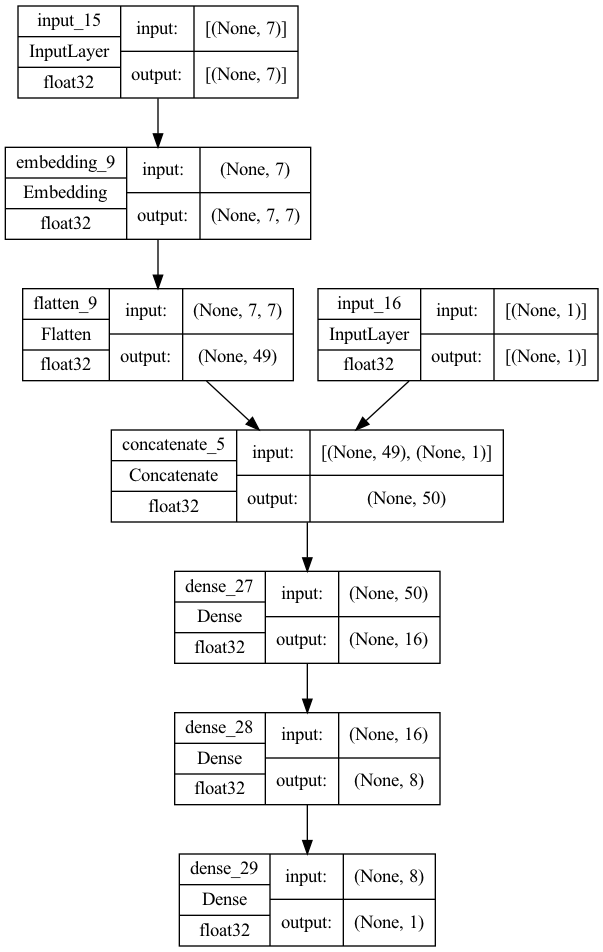

In [78]:
plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True, to_file='model_1.png')

In [76]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(),
              metrics=[Accuracy()])
              

# Train the model
model.fit([X_train[categorical_features], X_train[numerical_features]], y_train,batch_size=8,epochs=10)

# Evaluate the model
loss, accuracy = model.evaluate([X_test[categorical_features], X_test[numerical_features]], y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Epoch 1/10


ValueError: in user code:

    File "/Users/sachar/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/sachar/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/sachar/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/sachar/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/Users/sachar/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/sachar/opt/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_8" is incompatible with the layer: expected shape=(None, 128), found shape=(None, 7)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

In [163]:
embedding_dim = 100
embedding_index = {}


with open('glove.6B.100d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.splite()
        word = values[0]
        coefs = np.asarray(values[1:],dtype='float32')
        embedding_index[word]=coefs

In [87]:
# Label encoding for the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Tokenize and convert textual features to numerical sequences
max_words = 1000  # Maximum number of words to consider
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X['description'])
X_text1 = tokenizer.texts_to_sequences(X['description'])


In [88]:
# Pad sequences to have the same length
max_seq_length = max(len(seq) for seq in X_text1)
X_text1 = pad_sequences(X_text1, maxlen=max_seq_length)

In [39]:
X_train_text1, X_test_text1,y_train, y_test = train_test_split(
    X_text1, y, test_size=0.2, random_state=42
)

# Define the graph model
# Input layers for textual features
text_input_1 = Input(shape=(max_seq_length,))

In [43]:
# Embedding layers for textual features
embedding_dim = 16
embedding_1 = Embedding(input_dim=max_words, output_dim=embedding_dim)(text_input_1)

# Flatten the embeddings
flatten_1 = Flatten()(embedding_1)

# Concatenate flattened embeddings with dense layers for classification
concatenated = Concatenate()([flatten_1])
x = Dense(64, activation='relu')(concatenated)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

In [45]:
# Create the model
model = Model(inputs=[text_input_1], outputs=output)

In [46]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 99)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 99, 16)            16000     
                                                                 
 flatten_4 (Flatten)         (None, 1584)              0         
                                                                 
 concatenate_2 (Concatenate)  (None, 1584)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                101440    
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33  

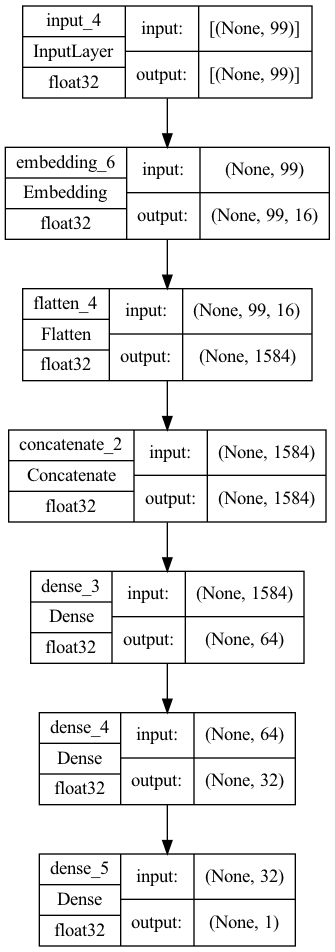

In [47]:
plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True, to_file='model_1.png')

In [48]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(),
              metrics=[Accuracy()])

# Train the model
model.fit([X_train_text1], y_train,
          batch_size=32,
          epochs=10,
          validation_data=([X_test_text1], y_test))

# Evaluate the model
loss, accuracy = model.evaluate([X_test_text1], y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Epoch 1/10
250/250 [==============================] - 1s 2ms/step - loss: -82531.5547 - accuracy: 0.0039 - val_loss: -453796.5000 - val_accuracy: 0.0040
Epoch 2/10
250/250 [==============================] - 0s 2ms/step - loss: -3324467.2500 - accuracy: 0.0043 - val_loss: -9033358.0000 - val_accuracy: 0.0040
Epoch 3/10
250/250 [==============================] - 0s 2ms/step - loss: -24220028.0000 - accuracy: 0.0043 - val_loss: -47107068.0000 - val_accuracy: 0.0040
Epoch 4/10
250/250 [==============================] - 0s 2ms/step - loss: -88946872.0000 - accuracy: 0.0043 - val_loss: -145033568.0000 - val_accuracy: 0.0040
Epoch 5/10
250/250 [==============================] - 0s 2ms/step - loss: -230489424.0000 - accuracy: 0.0043 - val_loss: -338048192.0000 - val_accuracy: 0.0040
Epoch 6/10
250/250 [==============================] - 0s 2ms/step - loss: -483774496.0000 - accuracy: 0.0043 - val_loss: -661425792.0000 - val_accuracy: 0.0040
Epoch 7/10
250/250 [==============================] - 

In [55]:
from sklearn.model_selection import RandomizedSearchCV 